# Newton's method using variational equations

In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

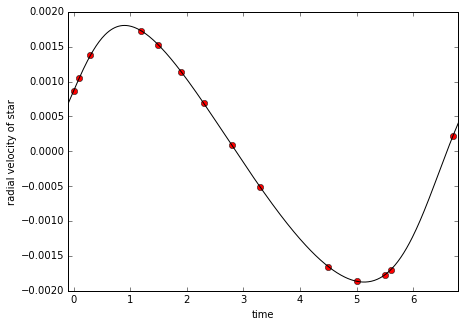

In [53]:
sample_times = np.array([0.,0.1,0.3,1.2,1.5,1.9,2.3,2.8,3.3,4.5,5,5.5,5.6,6.7])
def simple(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    samples = np.zeros((len(sample_times)))
    for i,t in enumerate(sample_times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return samples
def plotpoints(x,N):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    samples = np.zeros((N))
    times = np.linspace(sample_times[0]-0.1,sample_times[-1]+0.1,N)
    for i,t in enumerate(times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return times, samples

x_true = (1.0,0.2500)
samples_true = simple(x_true)
t,s = plotpoints(x_true,400)
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)

ax.set_xlabel("time")
ax.set_xlim(t[0],t[-1])
ax.set_ylabel("radial velocity of star")
im = ax.plot(sample_times, samples_true, "ro")
im = ax.plot(t, s, "r-",color="black")
plt.savefig('paper_test3a.pdf',bbox_inches='tight')

In [3]:
def evaluate(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    
    var_da    = sim.add_variational()
    var_dda   = sim.add_variational(order=2,index_1st_order_a=var_da,index_1st_order_b=var_da)
    var_de    = sim.add_variational()
    var_dde   = sim.add_variational(order=2,index_1st_order_a=var_de,index_1st_order_b=var_de)
    var_da_de = sim.add_variational(order=2,index_1st_order_a=var_da,index_1st_order_b=var_de)
    sim._particles[var_da+1]    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a")
    sim._particles[var_de+1]    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e")
    sim._particles[var_dda+1]   = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a",variation_order=2)
    sim._particles[var_dde+1]   = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e",variation_order=2)
    sim._particles[var_da_de+1] = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a",variation2="e",variation_order=2)

    sim.move_to_com()
    
    l = 0.
    d = np.zeros((2))
    dd = np.zeros((2,2))
    
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
        d[0] += 2. * sim.particles[var_da].vx*(rv-rvobs)
        d[1] += 2. * sim.particles[var_de].vx*(rv-rvobs)
        dd[0][0] += 2. * sim.particles[var_dda].vx*(rv-rvobs)
        dd[0][0] += 2. * sim.particles[var_da].vx*sim.particles[var_da].vx
        dd[1][0] += 2. * sim.particles[var_da_de].vx*(rv-rvobs)
        dd[1][0] += 2. * sim.particles[var_da].vx*sim.particles[var_de].vx
        dd[1][1] += 2. * sim.particles[var_dde].vx*(rv-rvobs)
        dd[1][1] += 2. * sim.particles[var_de].vx*sim.particles[var_de].vx

    dd[0][1] = dd[1][0]

                     
    return l, d, dd

In [4]:
def softabs(hessians):
    alpha = 100000.1
    lam, Q = np.linalg.eig(-hessians)
    lam_twig = lam*1./np.tanh(alpha*lam)
    H_twig = np.dot(Q,np.dot(np.diag(lam_twig),Q.T))    
    return H_twig

In [43]:
x = np.array((0.91, 0.12))
N_it = 30
chain = np.zeros((N_it,2))
for i in range(N_it):    
    f, df, ddf = evaluate(x)
    
    G = softabs(ddf)
    Delta_x = -np.dot(np.linalg.inv(G),df)
    #Delta_x = np.array((-df[0]/ddf[0][0],0))
    #Delta_x = - np.array((1./ddf[0][0]*df[0],0))
    #Delta_x = - np.array((0.,1./ddf[1][1]*df[1]))
    
    #Delta_x = -df
    chain[i] = ( x)
    x = x + Delta_x
    

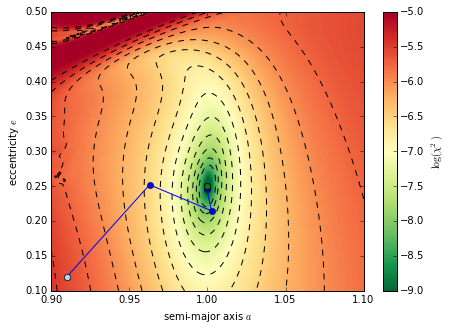

In [60]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(grid_a),max(grid_a),min(grid_e),max(grid_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
matplotlib.rcParams['contour.negative_linestyle'] = 'dashed'
im = ax.imshow(np.log10(grid), cmap="RdYlGn_r", vmin=-9, vmax = -5, origin="lower",aspect='auto', extent=extent) #interpolation="none",
ax.contour(grid_a, grid_e, np.clip(np.log10(grid),-8.5,-5),locator=plt.LinearLocator(numticks=15),colors="black")
ax.plot(chain[:,0],chain[:,1],color="blue")
ax.plot(chain[:,0],chain[:,1],"ro",color="blue")
ax.plot(x_true[0],x_true[1],"ro",color="green")
ax.plot(chain[0,0],chain[0,1],"ro",color="lightblue")
cb = plt.colorbar(im, ax=ax)
cb.set_label('$\log(\chi^2)$')
plt.savefig('paper_test3b.pdf',bbox_inches='tight')

In [51]:
def simple_grad(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    l = 0.
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
    return l

In [8]:
N=150
grid = np.zeros((N,N))
grid_a = np.linspace(0.9,1.1,N)
grid_e = np.linspace(0.1,0.5,N)
for i, a in enumerate(grid_a):
    for j, e in enumerate(grid_e):
        l = simple_grad((a,e))
        grid[j][i] = l

In [98]:
Delta = 0.00001
a, e = (0.9,.25)
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
var_da    = sim.add_variational()
var_dda   = sim.add_variational(order=2,index_1st_order_a=var_da,index_1st_order_b=var_da)
var_de    = sim.add_variational()
var_dde   = sim.add_variational(order=2,index_1st_order_a=var_de,index_1st_order_b=var_de)
var_da_de = sim.add_variational(order=2,index_1st_order_a=var_da,index_1st_order_b=var_de)
sim._particles[var_da+1]    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a")
sim._particles[var_de+1]    = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e")
sim._particles[var_dda+1]   = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a",variation_order=2)
sim._particles[var_dde+1]   = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="e",variation_order=2)
sim._particles[var_da_de+1] = rebound.Particle(simulation=sim,primary=sim.particles[0],a=a,m=1e-3,e=e,variation="a",variation2="e",variation_order=2)

sim.move_to_com()
l = 0.
d = np.zeros((2))
dd = np.zeros((2,2))

for i, t in enumerate(sample_times):
    sim.integrate(t)
    rvobs = samples_true[i]
    rv = sim.particles[0].vx
    l += (rv-rvobs)*(rv-rvobs)
    d[0] += 2. * sim.particles[var_da].vx*(rv-rvobs)
    d[1] += 2. * sim.particles[var_de].vx*(rv-rvobs)
    dd[0][0] += 2. * sim.particles[var_dda].vx*(rv-rvobs)
    dd[0][0] += 2. * sim.particles[var_da].vx*sim.particles[var_da].vx
    dd[1][0] += 2. * sim.particles[var_da_de].vx*(rv-rvobs)
    dd[1][0] += 2. * sim.particles[var_da].vx*sim.particles[var_de].vx
    dd[1][1] += 2. * sim.particles[var_dde].vx*(rv-rvobs)
    dd[1][1] += 2. * sim.particles[var_de].vx*sim.particles[var_de].vx
print d
dd[0][1] = dd[1][0]
print dd

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(primary=sim.particles[0],m=1e-3, a=a+Delta, e=e+Delta)
sim.move_to_com()
lpp = 0.
for i, t in enumerate(sample_times):
    sim.integrate(t)
    rvobs = samples_true[i]
    rv = sim.particles[0].vx
    lpp += (rv-rvobs)*(rv-rvobs)
    
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(primary=sim.particles[0],m=1e-3, a=a-Delta, e=e-Delta)
sim.move_to_com()
lmm = 0.
for i, t in enumerate(sample_times):
    sim.integrate(t)
    rvobs = samples_true[i]
    rv = sim.particles[0].vx
    lmm += (rv-rvobs)*(rv-rvobs)    
    
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(primary=sim.particles[0],m=1e-3, a=a+Delta, e=e-Delta)
sim.move_to_com()
lpm = 0.
for i, t in enumerate(sample_times):
    sim.integrate(t)
    rvobs = samples_true[i]
    rv = sim.particles[0].vx
    lpm += (rv-rvobs)*(rv-rvobs)   
    
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(primary=sim.particles[0],m=1e-3, a=a-Delta, e=e+Delta)
sim.move_to_com()
lmp = 0.
for i, t in enumerate(sample_times):
    sim.integrate(t)
    rvobs = samples_true[i]
    rv = sim.particles[0].vx
    lmp += (rv-rvobs)*(rv-rvobs)  
    
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e+Delta)
sim.move_to_com()
l0p = 0.
for i, t in enumerate(sample_times):
    sim.integrate(t)
    rvobs = samples_true[i]
    rv = sim.particles[0].vx
    l0p += (rv-rvobs)*(rv-rvobs)  

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(primary=sim.particles[0],m=1e-3, a=a+Delta, e=e)
sim.move_to_com()
lp0 = 0.
for i, t in enumerate(sample_times):
    sim.integrate(t)
    rvobs = samples_true[i]
    rv = sim.particles[0].vx
    lp0 += (rv-rvobs)*(rv-rvobs)  

print ""


print np.array(((lpp-lmp)/(2.*Delta),(lpp-lpm)/(2.*Delta)))
print np.array(( 
        ((lpp-2.*l0p+lmp)/(Delta*Delta),
        (lpp-lmp-lpm+lmm)/(4.*Delta*Delta)),
        ((lpp-lmp-lpm+lmm)/(4.*Delta*Delta),
        (lpp-2.*lp0+lpm)/(Delta*Delta))))

[ -1.20384691e-04   4.47384907e-06]
[[  1.21479321e-03  -2.81803428e-04]
 [ -2.81803428e-04   3.27016281e-05]]

[ -1.20387508e-04   4.47103098e-06]
[[  1.21478058e-03  -2.81802807e-04]
 [ -2.81802807e-04   3.26910248e-05]]


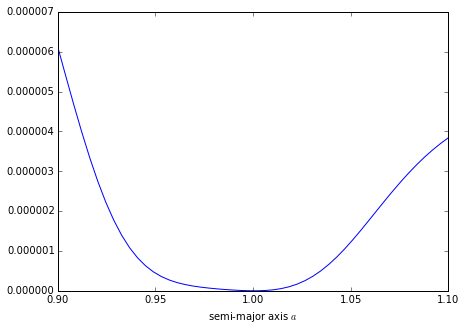

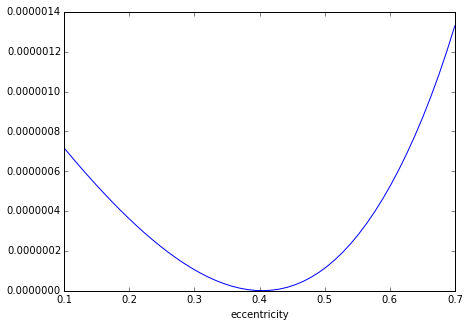

In [69]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.set_xlabel("semi-major axis $a$")
im = ax.plot(grid_a,grid[N/2,:])
fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
ax.set_xlabel("eccentricity")
im = ax.plot(grid_e,grid[:,N/2])